# Randomized Image Sampling for Explanations (RISE)

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from utils import *
from explanations import RISE

cudnn.benchmark = True

In [2]:
args = Dummy()

# Number of workers to load data
args.workers = 8
# Directory with images split into class folders.
# Since we don't use ground truth labels for saliency all images can be 
# moved to one class folder.
args.datadir = 'C:/stuff/rise-imagenet-2012/'
# Sets the range of images to be explained for dataloader.
args.range = range(95, 105)
# Size of imput images.
args.input_size = (224, 224)
# Size of batches for GPU. 
# Use maximum number that the GPU allows. Default was 250
args.gpu_batch = 25

## Prepare data

In [3]:
dataset = datasets.ImageFolder(args.datadir, preprocess)

# This example only works with batch size 1. For larger batches see RISEBatch in explanations.py.
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=False,
    num_workers=args.workers, pin_memory=True, sampler=RangeSampler(args.range))

print('Found {: >5} images belonging to {} classes.'.format(len(dataset), len(dataset.classes)))
print('      {: >5} images will be explained.'.format(len(data_loader) * data_loader.batch_size))

Found 50000 images belonging to 1 classes.
         10 images will be explained.


## Load black-box model

In [4]:
# Load black box model for explanations
model = models.resnet50(True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
model = model.cuda()

for p in model.parameters():
    p.requires_grad = False
    
# To use multiple GPUs
model = nn.DataParallel(model)

## Create explainer instance

In [5]:
explainer = RISE(model, args.input_size, args.gpu_batch)

In [6]:
# Generate masks for RISE or use the saved ones.
maskspath = 'masks.npy'
generate_new = True

if generate_new or not os.path.isfile(maskspath):
    explainer.generate_masks(N=6000, s=8, p1=0.1, savepath=maskspath)
else:
    explainer.load_masks(maskspath)
    print('Masks are loaded.')

Generating filters: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:12<00:00, 468.16it/s]


## Explaining one instance
Producing saliency maps for top $k$ predicted classes.

In [7]:
def example(img, top_k=3):
    saliency = explainer(img.cuda()).cpu().numpy()
    p, c = torch.topk(model(img.cuda()), k=top_k)
    p, c = p[0], c[0]
    
    plt.figure(figsize=(10, 5*top_k))
    for k in range(top_k):
        plt.subplot(top_k, 2, 2*k+1)
        plt.axis('off')
        plt.title('{:.2f}% {}'.format(100*p[k], get_class_name(c[k])))
        tensor_imshow(img[0])

        plt.subplot(top_k, 2, 2*k+2)
        plt.axis('off')
        plt.title(get_class_name(c[k]))
        tensor_imshow(img[0])
        sal = saliency[c[k]]
        plt.imshow(sal, cmap='jet', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.04)

    plt.show()

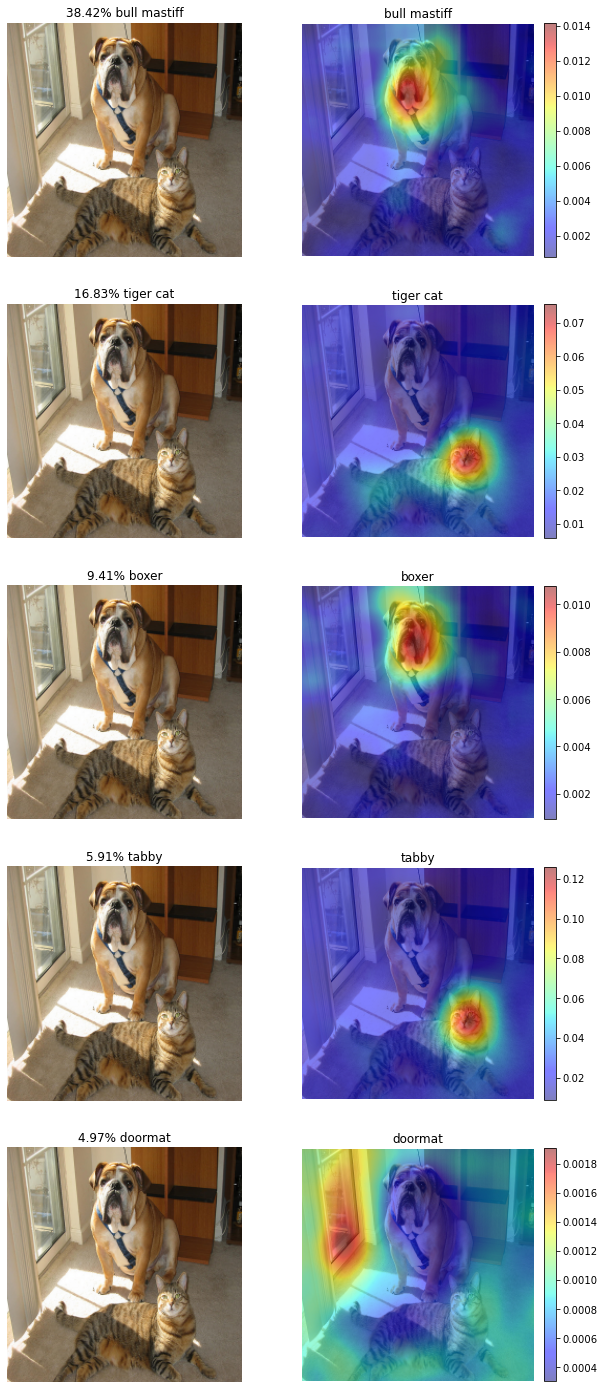

In [8]:
example(read_tensor('catdog.png'), 5)

## Explaining all images in dataloader
Explaining the top predicted class for each image.

In [9]:
def explain_all(data_loader, explainer):
    # Get all predicted labels first
    target = np.empty(len(data_loader), np.int)
    for i, (img, _) in enumerate(tqdm(data_loader, total=len(data_loader), desc='Predicting labels')):
        p, c = torch.max(model(img.cuda()), dim=1)
        target[i] = c[0]

    # Get saliency maps for all images in val loader
    explanations = np.empty((len(data_loader), *args.input_size))
    for i, (img, _) in enumerate(tqdm(data_loader, total=len(data_loader), desc='Explaining images')):
        saliency_maps = explainer(img.cuda())
        explanations[i] = saliency_maps[target[i]].cpu().numpy()
    return explanations

In [10]:
explanations = explain_all(data_loader, explainer)

# Save explanations if needed.
# explanations.tofile('exp_{:05}-{:05}.npy'.format(args.range[0], args.range[-1]))

C:\Users\DMITRI~1\AppData\Local\Temp/ipykernel_9396/2044388317.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  target = np.empty(len(data_loader), np.int)
Explaining images: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:44<00:00, 10.42s/it]


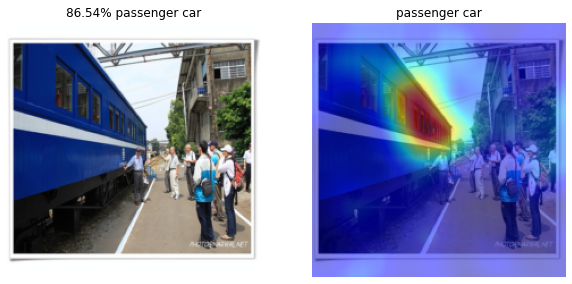

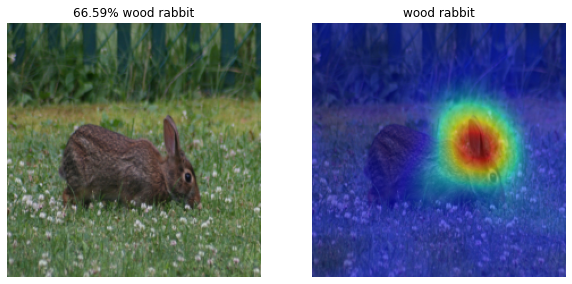

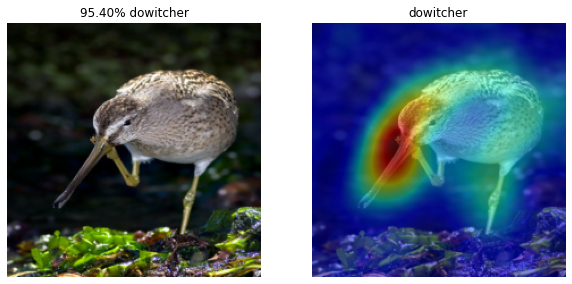

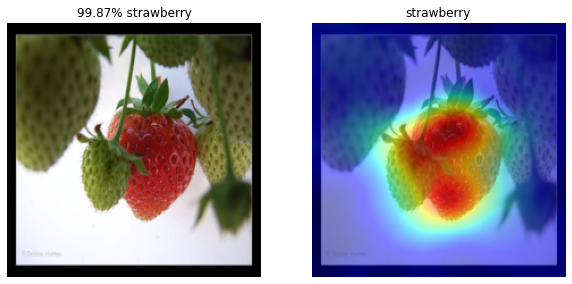

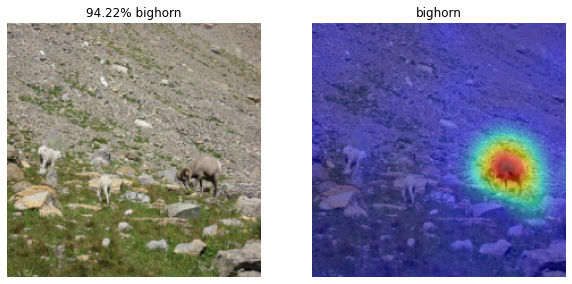

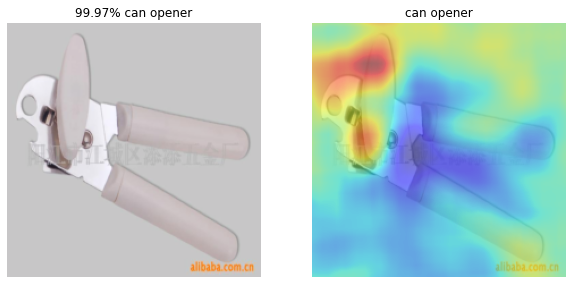

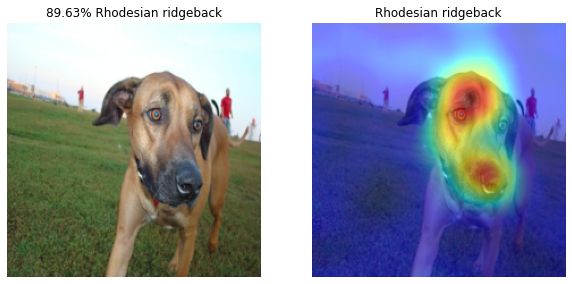

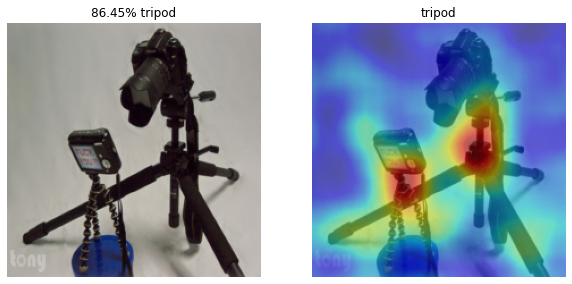

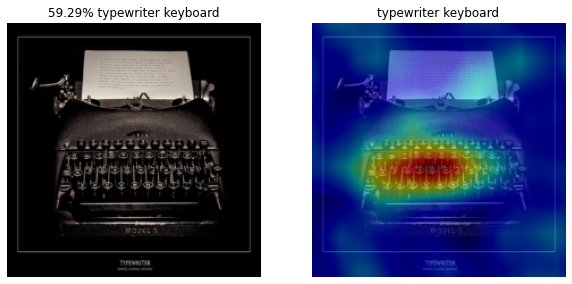

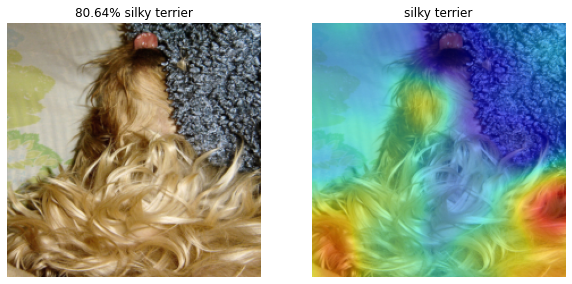

In [11]:
for i, (img, _) in enumerate(data_loader):
    p, c = torch.max(model(img.cuda()), dim=1)
    p, c = p[0].item(), c[0].item()
    
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.axis('off')
    plt.title('{:.2f}% {}'.format(100*p, get_class_name(c)))
    tensor_imshow(img[0])
    
    plt.subplot(122)
    plt.axis('off')
    plt.title(get_class_name(c))
    tensor_imshow(img[0])
    sal = explanations[i]
    plt.imshow(sal, cmap='jet', alpha=0.5)
    #plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.show()